# Using Methods from Homework Assignment to Look at Tennessee Valley

In [2]:
import pandas as pd
import datetime
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
import shap

/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load SPC tornado dataset
url = "https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv"
df = pd.read_csv(url, encoding="latin1")

# Filter for the selected states
states = ['AL', 'TN', 'MS']
df = df[df['st'].isin(states)]

# Create datetime and monthly aggregation
df['date'] = pd.to_datetime(dict(year=df.yr, month=df.mo, day=df.dy))
df['year_month'] = df['date'].dt.to_period('M')
df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,year_month
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,37,1,1,1,101,0,0,0,0,1950-11
25,16,1950,2,12,1950-02-12,12:00:00,3,MS,28,1,...,10,1,1,1,145,0,0,0,0,1950-02
26,17,1950,2,12,1950-02-12,12:00:00,3,MS,28,2,...,10,1,1,1,145,0,0,0,0,1950-02
34,25,1950,2,13,1950-02-13,01:00:00,3,TN,47,1,...,10,1,1,1,157,0,0,0,0,1950-02
35,26,1950,2,13,1950-02-13,02:00:00,3,TN,47,2,...,10,1,1,1,97,0,0,0,0,1950-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67487,620503,2021,8,30,2021-08-30,13:02:00,3,AL,1,0,...,75,1,1,1,109,0,0,0,0,2021-08
67488,620504,2021,8,30,2021-08-30,14:45:00,3,AL,1,0,...,75,1,1,1,87,0,0,0,0,2021-08
67489,620505,2021,8,31,2021-08-31,14:59:00,3,AL,1,0,...,20,1,1,1,69,0,0,0,0,2021-08
67492,620508,2021,8,31,2021-08-31,17:14:00,3,AL,1,0,...,125,1,1,1,45,0,0,0,0,2021-08


In [4]:
# Count tornadoes per month over all selected states
monthly_total = (df.groupby('year_month').size().reset_index(name='tornado_count'))
monthly_total['year_month'] = monthly_total['year_month'].dt.to_timestamp()
monthly_total

,year_month,tornado_count
0,1950-02-01,4
1,1950-03-01,8
2,1950-04-01,3
3,1950-05-01,2
4,1950-06-01,1
...,...,...
636,2021-06-01,10
637,2021-08-01,24
638,2021-10-01,4
639,2021-11-01,1


In [5]:
# From Module 4 Notebook 1
enso = pd.read_csv('https://www.esrl.noaa.gov/psd/data/correlation/censo.data',sep=r'\s+',header=None,skiprows=1,skipfooter=2, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()

enso_new['Date']=pd.date_range(start=datetime.datetime(enso[0].iloc[0],1,1),end=datetime.datetime(enso[0].iloc[-1],12,1),freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),end=datetime.datetime(nao[0].iloc[-1],12,1),freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),end=datetime.datetime(pdo[0].iloc[-1],12,1),freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),end=datetime.datetime(ao[0].iloc[-1],12,1),freq="MS")

enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')

enso_new['ENSO']=enso.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values

newdf_all = pd.merge(enso_new,pdo_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['PDO'] > 90.,'PDO'] = np.nan
newdf_all.loc[newdf_all['ENSO'] <= -9.9,'ENSO'] = np.nan
newdf_all = pd.merge(newdf_all,nao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['NAO'] <= -99.9,'NAO'] = np.nan
newdf_all = pd.merge(newdf_all,ao_new, left_index=True, right_index=True)
newdf_all.loc[newdf_all['AO'] <= -99.9,'AO'] = np.nan

newdf_all

/tmp/ipykernel_3441/1187684440.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_3441/1187684440.py:24: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_3441/1187684440.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  

,ENSO,PDO,NAO,AO
Date,,,,
1950-01-01,-0.67,-1.61,0.92,-0.060
1950-02-01,-1.52,-2.17,0.40,0.627
1950-03-01,-1.37,-1.89,-0.36,-0.008
1950-04-01,-1.31,-1.99,0.73,0.555
1950-05-01,-1.26,-3.19,-0.59,0.072
...,...,...,...,...
2025-08-01,-0.38,-3.20,0.26,0.036
2025-09-01,NaN,-2.33,-0.80,0.048
2025-10-01,NaN,-2.40,-0.96,0.064


In [6]:
torn = monthly_total.copy()
torn = torn.rename(columns={'year_month': 'Date'}).set_index('Date').sort_index()

tele = newdf_all.sort_index()

# Inner join keeps overlap only 
merged = torn.join(tele, how='inner')
print(merged.isna().sum())
merged

tornado_count    0
ENSO             0
PDO              0
NAO              0
AO               0
dtype: int64


,tornado_count,ENSO,PDO,NAO,AO
Date,,,,,
1950-02-01,4,-1.52,-2.17,0.40,0.627
1950-03-01,8,-1.37,-1.89,-0.36,-0.008
1950-04-01,3,-1.31,-1.99,0.73,0.555
1950-05-01,2,-1.26,-3.19,-0.59,0.072
1950-06-01,1,-1.79,-2.52,-0.06,0.539
...,...,...,...,...,...
2021-06-01,10,-0.23,-1.82,0.77,0.845
2021-08-01,24,-0.70,-0.95,-0.28,-0.209
2021-10-01,4,-0.96,-3.13,-2.29,-0.146


In [7]:
# Prepare features and target
model_df = merged.dropna(subset=["ENSO", "PDO", "NAO", "AO", "tornado_count"]) # drop missing values for clean data
X = model_df[["ENSO", "PDO", "NAO", "AO"]]
y = model_df["tornado_count"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit Random Forest Regressor
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest R²: {r2:.3f}")
print(f"Random Forest RMSE: {rmse:.3f}")

Random Forest R²: -0.603
Random Forest RMSE: 12.861


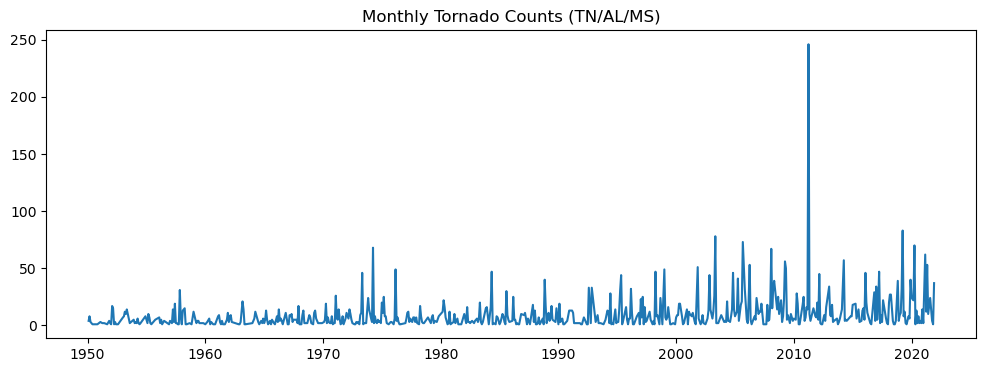

In [8]:
plt.figure(figsize=(12,4))
plt.plot(merged.index, merged['tornado_count'])
plt.title("Monthly Tornado Counts (TN/AL/MS)")
plt.show()

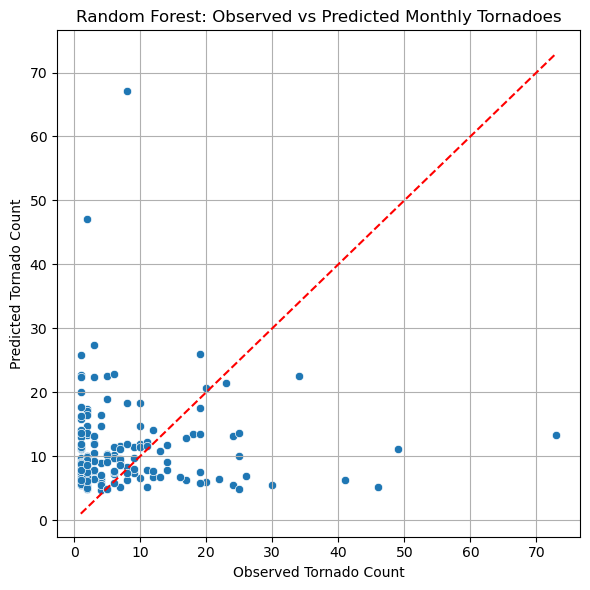

In [9]:
# Scatter plot: predicted vs observed
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Observed Tornado Count")
plt.ylabel("Predicted Tornado Count")
plt.title("Random Forest: Observed vs Predicted Monthly Tornadoes")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
y_true_test = y_test.values
r, p = pearsonr(y_true_test, y_pred)

print("Correlation coefficient (Pearson r):", r)
print("p-value:", p)

Correlation coefficient (Pearson r): 0.002613925930448096
p-value: 0.9737474550005595


In [11]:
df = merged.copy()

# Extract month and one-hot encode
df['month'] = df.index.month
month_ohe = pd.get_dummies(df['month'], prefix='m')

# Combine climate indices + month_ohe
X = pd.concat([df[['ENSO','PDO','NAO','AO']], month_ohe], axis=1)
y = df['tornado_count'].values

In [12]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Fit Random Forest
rf2 = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
rf2.fit(X_train, y_train)

# Predictions
y_pred = rf2.predict(X_test)

# Compute RMSE + Pearson correlation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r, p = pearsonr(y_test, y_pred)

print("RMSE:", rmse)
print("Correlation coefficient (r):", r)
print("p-value:", p)

RMSE: 25.111647918112787
Correlation coefficient (r): 0.2432705149243834
p-value: 0.0018736855874411714


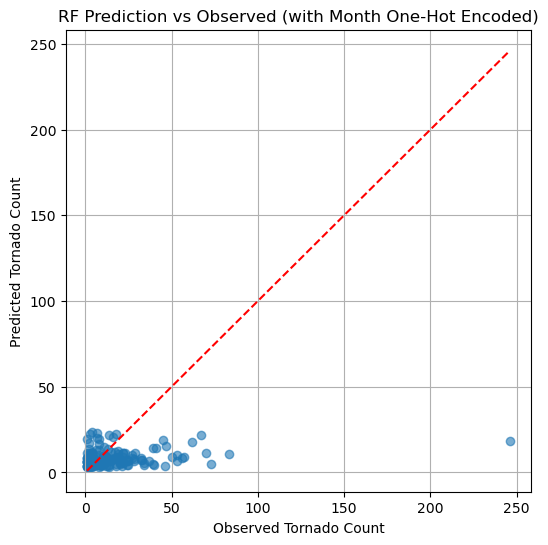

In [13]:
# Scatterplot
plt.figure(figsize=(6,6))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Observed Tornado Count")
plt.ylabel("Predicted Tornado Count")
plt.title("RF Prediction vs Observed (with Month One-Hot Encoded)")
plt.grid(True)
plt.show()

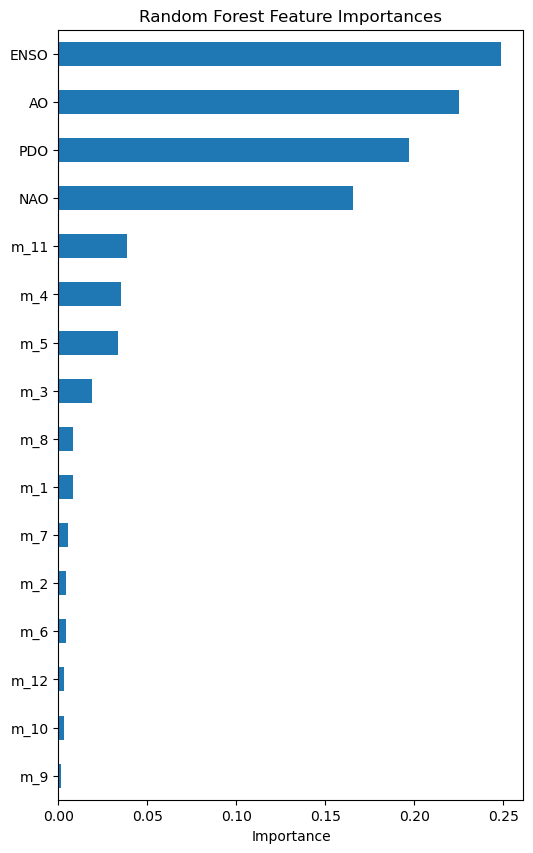

m_9     0.001562
m_10    0.003178
m_12    0.003285
m_6     0.003966
m_2     0.003971
m_7     0.005285
m_1     0.008059
m_8     0.008391
m_3     0.018633
m_5     0.033521
m_4     0.035247
m_11    0.038306
NAO     0.165671
PDO     0.197172
AO      0.224841
ENSO    0.248911
dtype: float64

In [14]:
# Feature importance
importances = pd.Series(rf2.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(6,10))
importances_sorted.plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

importances_sorted

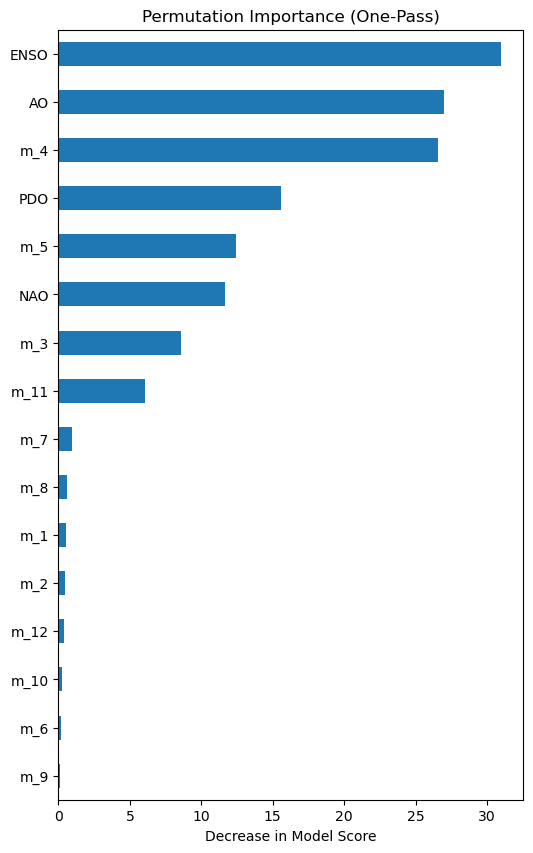

m_9      0.113936
m_6      0.163408
m_10     0.224746
m_12     0.352170
m_2      0.440914
m_1      0.537038
m_8      0.610710
m_7      0.961519
m_11     6.042169
m_3      8.553565
NAO     11.643657
m_5     12.410164
PDO     15.567762
m_4     26.533636
AO      26.978573
ENSO    31.000866
dtype: float64

In [15]:
# permutation importance
# This measures how much prediction error increases when each feature is randomly shuffled
perm = permutation_importance(rf2, X, y, n_repeats=10, random_state=42, scoring="neg_mean_squared_error")

perm_imp = pd.Series(perm.importances_mean, index=X.columns)
perm_imp_sorted = perm_imp.sort_values()

plt.figure(figsize=(6,10))
perm_imp_sorted.plot(kind='barh')
plt.title("Permutation Importance (One-Pass)")
plt.xlabel("Decrease in Model Score")
plt.show()

perm_imp_sorted

In [16]:
def multipass_permutation(model, X, y, passes=10):
    remaining = list(X.columns)
    results = []

    X_current = X.copy()

    for i in range(min(passes, len(remaining))):
        # Fit model
        model.fit(X_current, y)

        # Get permutation importance
        perm = permutation_importance(model, X_current, y, n_repeats=8, random_state=42, scoring="neg_mean_squared_error")
        imp = pd.Series(perm.importances_mean, index=X_current.columns)

        # Most important feature
        top_feature = imp.idxmax()
        top_importance = imp.max()

        results.append((i+1, top_feature, top_importance))
        print(f"Pass {i+1}: Removing '{top_feature}' (importance={top_importance:.4f})")

        # Remove it
        X_current = X_current.drop(columns=[top_feature])

    return pd.DataFrame(results, columns=["Pass", "Removed Feature", "Importance"])

# Run multipass permutation analysis
mp_results = multipass_permutation(rf2, X, y, passes=15)

mp_results

Pass 1: Removing 'AO' (importance=102.6253)
Pass 2: Removing 'NAO' (importance=125.5540)
Pass 3: Removing 'ENSO' (importance=186.0677)
Pass 4: Removing 'PDO' (importance=206.3901)
Pass 5: Removing 'm_4' (importance=29.8373)
Pass 6: Removing 'm_7' (importance=19.5412)
Pass 7: Removing 'm_6' (importance=8.4108)
Pass 8: Removing 'm_8' (importance=1.8943)
Pass 9: Removing 'm_3' (importance=0.9969)
Pass 10: Removing 'm_10' (importance=0.7089)
Pass 11: Removing 'm_5' (importance=0.6214)
Pass 12: Removing 'm_9' (importance=0.7186)
Pass 13: Removing 'm_11' (importance=0.4536)
Pass 14: Removing 'm_12' (importance=0.4849)
Pass 15: Removing 'm_1' (importance=0.3361)


,Pass,Removed Feature,Importance
0,1,AO,102.625344
1,2,NAO,125.554013
2,3,ENSO,186.067734
3,4,PDO,206.390066
4,5,m_4,29.837312
5,6,m_7,19.541227
6,7,m_6,8.410794
7,8,m_8,1.894308
8,9,m_3,0.996886
9,10,m_10,0.708941


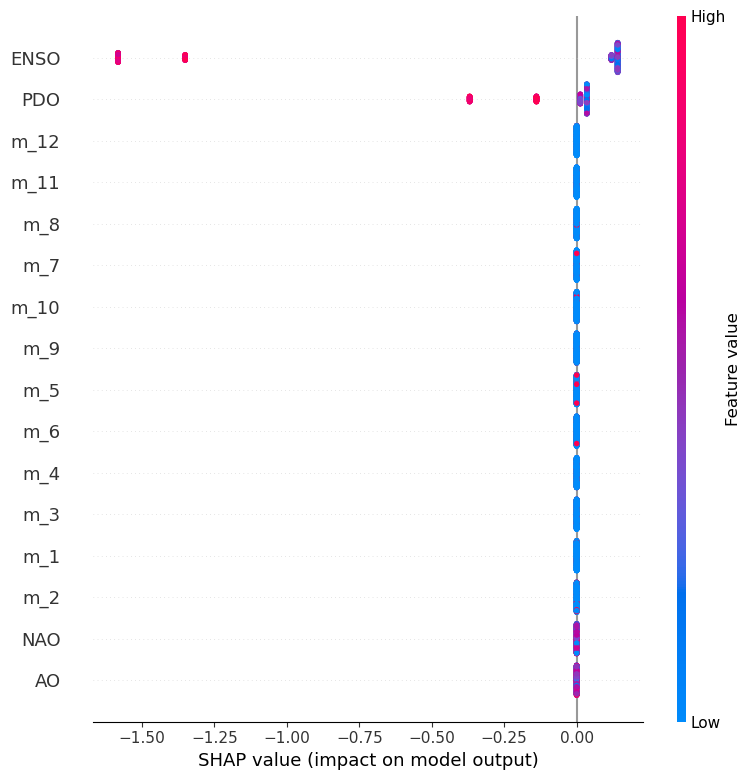

In [17]:
# Build SHAP explainer
explainer = shap.TreeExplainer(rf2)
shap_values = explainer(X)

# Beeswarm summary plot: importance + feature effects
shap.summary_plot(shap_values, X, show=True)

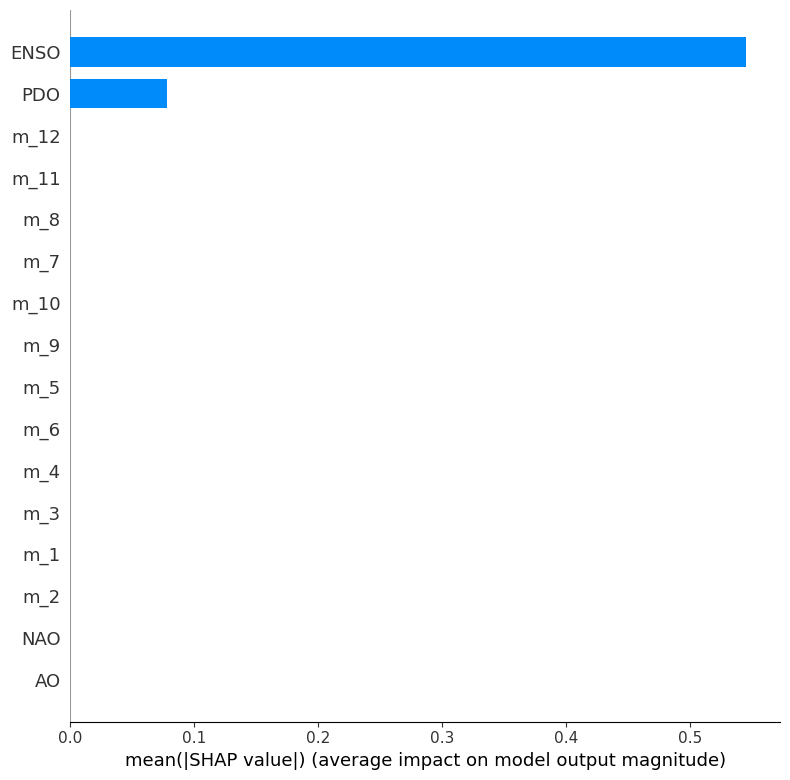

In [18]:
shap.summary_plot(shap_values, X, plot_type="bar")

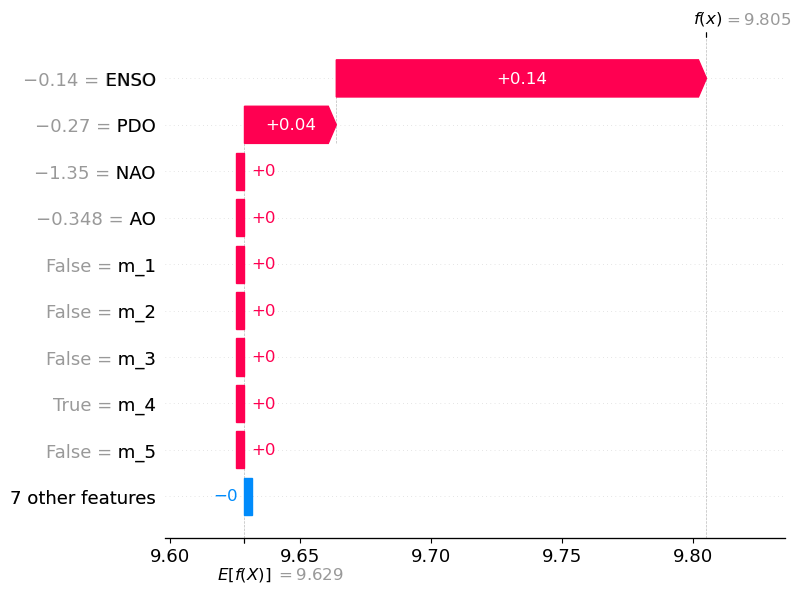

In [19]:
# explain random observation (100th)
explainer = shap.TreeExplainer(rf2)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[100])

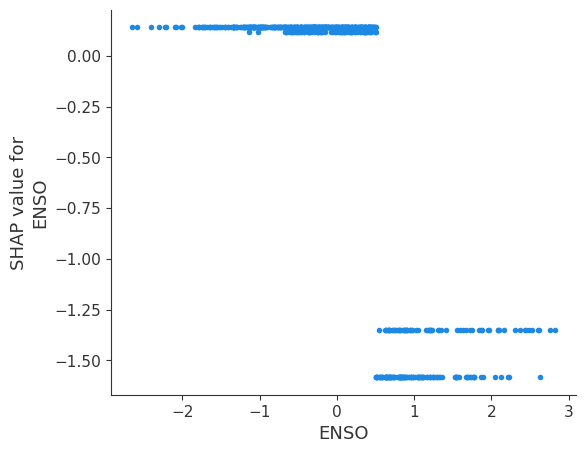

In [20]:
# Create a dependence plot specifically for ENSO
shap.dependence_plot("ENSO", shap_values.values, X, interaction_index=None) # SHAP chooses strongest interacting feature

The SHAP dependence plot for ENSO in the Deep South (AL/TN/MS) shows a clear two-regime relationship.
When ENSO values exceed +1 (El Niño), SHAP values become strongly negative (–1.3 to –1.6), indicating that the model reduces the tornado prediction during El Niño months. Conversely, for neutral and La Niña conditions (ENSO < +0.5), SHAP values are near zero to slightly positive, meaning the model slightly increases predicted tornado counts.

This reveals that in the Deep South, El Niño suppresses tornado activity while La Niña enhances it.

ENSO affects tornado activity differently by region!!!